In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import functools
import string
import joblib
import warnings
import itertools

In [2]:
%matplotlib inline
plt.ioff()
sns.set_style('darkgrid')
sns.set_context('talk')

In [3]:
from utilities import *

In [4]:
%load_ext autoreload
%autoreload 2

# Part 1: Load and Examine the Data

In [5]:
col_rename = lambda df : df.rename(lambda s : s.lower().replace(' ', '_'), axis = 'columns')

data           = col_rename(pd.read_csv('movie_train.csv', index_col=0))
out_of_sample  = col_rename(pd.read_csv('movie_test.csv' , index_col=0))
oos = out_of_sample # alias

data.head()

,release_year,title,plot,director,cast,genre
10281,1984,Silent Madness,A computer error leads to the accidental relea...,Simon Nuchtern,"Belinda Montgomery, Viveca Lindfors",horror
7341,1960,Desire in the Dust,"Lonnie Wilson (Ken Scott), the son of a sharec...",Robert L. Lippert,"Raymond Burr, Martha Hyer, Joan Bennett",drama
10587,1986,On the Edge,"A gaunt, bushy-bearded, 44-year-old Wes Holman...",Rob Nilsson,"Bruce Dern, Pam Grier",drama
25495,1988,Ram-Avtar,Ram and Avtar are both childhood best friends....,Sunil Hingorani,"Sunny Deol, Anil Kapoor, Sridevi",drama
16607,2013,Machete Kills,Machete Cortez (Danny Trejo) and Sartana River...,Robert Rodriguez,"Danny Trejo, Michelle Rodriguez, Sofía Vergara...",action


In [6]:
# Convenience function to view calls on 
#  training data and out-of-sample data
#  simultaneously
def compare(*attrs):
    ss = [data, out_of_sample]
    for attr in attrs:
        if attr[-2:] == '()':
            ss = lmap(lambda s : s.__getattr__(attr[:-2]).__call__(), ss)
        else:
            ss = lmap(lambda s : s.__getattr__(attr), ss)
    ss = [s.rename(name) for s, name in zip(ss, ['data', 'out_of_sample'])]
    return pd.concat(ss, axis = 'columns', sort = True)

In [7]:
# Check correct loading of datatypes
compare('dtypes')

,data,out_of_sample
cast,object,object
director,object,object
genre,object,NaN
plot,object,object
release_year,int64,int64
title,object,object


## 1 - Look for missing values

In [8]:
compare('isna()', 'sum()')

,data,out_of_sample
cast,169,57.0
director,0,0.0
genre,0,NaN
plot,0,0.0
release_year,0,0.0
title,0,0.0


In [9]:
print(data.shape, oos.shape)

(10682, 6) (3561, 5)


In [10]:
data[data.cast.isna()].head()

,release_year,title,plot,director,cast,genre
22523,2004,Kekexili: Mountain Patrol,The film opens with the summary execution of a...,Lu Chuan,NaN,drama
34135,2007,Dead Daughters,"In present-day Moscow, a woman Vera (Daria Cha...",Pavel Ruminov,NaN,horror
12958,1997,Defying Gravity,"John ""Griff"" Griffith, an average college stud...",John Keitel,NaN,drama
12937,1997,Cannibal Rollerbabes,When Scott is fired from Local Diner because h...,Unknown,NaN,horror
22329,2013,Stay,"The movie Stay, based on the novel by Aislinn ...",Wiebke von Carolsfeld,NaN,drama


## 1 - Look at the target

In [11]:
data.genre.value_counts()

drama        3770
comedy       2724
horror        840
action        830
thriller      685
romance       649
western       525
adventure     331
crime         328
Name: genre, dtype: int64

## 1 - Look at the overlap of directors

In [12]:
# There is pretty substantial overlap in directorship
#  Note that 'unknown' is a director
directors = compare('director', 'value_counts()').sort_values('out_of_sample', ascending = False)
directors = directors[(~directors.data.isna()) & (~directors.out_of_sample.isna())]
print(directors.sum())
directors.head()

data             5130.0
out_of_sample    2354.0
dtype: float64


,data,out_of_sample
Unknown,99.0,36.0
Lesley Selander,24.0,11.0
Allan Dwan,12.0,9.0
Charles Lamont,7.0,9.0
Otto Preminger,6.0,8.0


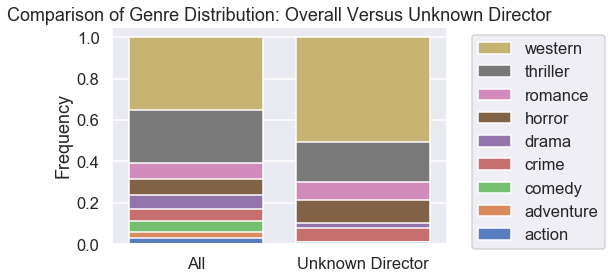

In [13]:
# There appears to be substantial information available in the unknown directors
fig, ax = stacked_countplot(
                  data.genre.rename('All'),
                  data[data.director == 'Unknown'].genre.rename('Unknown Director'),
                  normalize = True
                 )
ax.set_title('Comparison of Genre Distribution: Overall Versus Unknown Director')
plt.show()

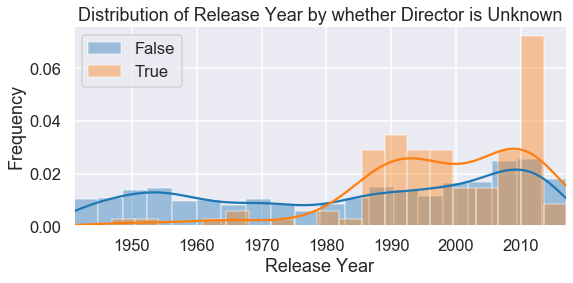

In [14]:
data['is_unknown_director'] = data.director == 'Unknown'

g = sns.FacetGrid(data, hue = 'is_unknown_director', height = 4, aspect = 2)
g.map(sns.distplot, 'release_year', bins = 20)

ax = g.fig.axes[0]
ax.set_xlim([data.release_year.min(), data.release_year.max()])
ax.set_xlabel('Release Year')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Release Year by whether Director is Unknown')
ax.legend()

drop_col(data, 'is_unknown_director')

plt.show()

In [15]:
# Many directors have only one movie in the training data
directors[directors.data == 1]

,data,out_of_sample
Robert Ellis Miller,1.0,4.0
Ben Stiller,1.0,4.0
S. V. Krishna Reddy,1.0,4.0
Roy William Neill,1.0,3.0
Anil Sharma,1.0,3.0
...,...,...
James Kenelm Clarke,1.0,1.0
James Keach,1.0,1.0
James F. Collier,1.0,1.0
James Cameron,1.0,1.0


Mean number of effective genres: 2.0


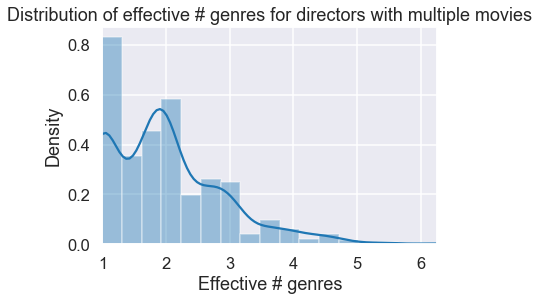

In [16]:
# Let's get a sense for how much information we can extract by
# computing the inverse herfindahl index on the 
# training data directors. This is the effective number
# of genres directed by a director.
def herfindahl_index(series):
    series = series.value_counts()
    return 1 / ((series/series.sum())**2).sum()
    
prolific_directors    = directors[directors.data > 1].data.index
prolific_directors    = data.director.isin(prolific_directors)

h = data[prolific_directors].groupby('director').genre.apply(herfindahl_index)
print(f'Mean number of effective genres: {round(h.mean(),1)}')

fig, ax = plt.subplots()
sns.distplot(h, ax = ax)
ax.set_xlim([1, max(h)])
ax.set_xlabel('Effective # genres')
ax.set_ylabel('Density')
ax.set_title('Distribution of effective # genres for directors with multiple movies')
plt.show()

## 1 - Look for uncoded missing values in plot

In [17]:
plot_len = data['plot'].apply(len).sort_values()
data.loc[plot_len.iloc[:5].index]

,release_year,title,plot,director,cast,genre
24876,1973,Chhalia,Chhalia is a family thriller.,Mukul Dutt,"Navin Nischol, Nanda, Shatrughan Sinha",action
6210,1954,They Were So Young,"""A beach near Rio de Janeiro"".",Kurt Neumann,"Raymond Burr, Scott Brady, Johanna Matz",drama
7382,1960,Noose for a Gunman,A gunman takes on a corrupt land baron.,Edward L. Cahn,"Jim Davis, Lyn Thomas",western
4075,1945,A Medal for Benny,The film examines small town hypocrisy.,Irving Pichel,"Dorothy Lamour, Arturo de Córdova",drama
25919,1997,Suraj,Suraj is an Action film for Mithun Fans.,T.L.V. Prasad,"Rakesh Bedi, Mithun Chakraborty, Puneet Issar",action


In [18]:
plot_len = oos['plot'].apply(len).sort_values()
oos.loc[plot_len.iloc[:5].index]

,release_year,title,plot,director,cast
7429,1960,Walk Like a Dragon,Film's introduction:,James Clavell,"Jack Lord, Nobu McCarthy, Mel Torme"
22731,2014,Blind Massage,The film is set in Nanjing.[1],Lou Ye,"Guo Xiaodong, Qin Hao, Zhang Lei, Mei Ting, Hu..."
17972,2007,Doctor Bari,The film is about three doctors.,M Azijur Rahman,"Shakib Khan, Shabnaz"
17608,1991,Deadly,From the UK VHS slick for the movie:,Esben Storm,"Jerome Ehlers, Frank Gallacher, Lydia Miller"
18965,1951,Death Is a Number,A man is persecuted by the number 9.,Robert Henryson,"Terence Alexander, Lesley Osmond, Ingeborg von..."


In [19]:
data

,release_year,title,plot,director,cast,genre
10281,1984,Silent Madness,A computer error leads to the accidental relea...,Simon Nuchtern,"Belinda Montgomery, Viveca Lindfors",horror
7341,1960,Desire in the Dust,"Lonnie Wilson (Ken Scott), the son of a sharec...",Robert L. Lippert,"Raymond Burr, Martha Hyer, Joan Bennett",drama
10587,1986,On the Edge,"A gaunt, bushy-bearded, 44-year-old Wes Holman...",Rob Nilsson,"Bruce Dern, Pam Grier",drama
25495,1988,Ram-Avtar,Ram and Avtar are both childhood best friends....,Sunil Hingorani,"Sunny Deol, Anil Kapoor, Sridevi",drama
16607,2013,Machete Kills,Machete Cortez (Danny Trejo) and Sartana River...,Robert Rodriguez,"Danny Trejo, Michelle Rodriguez, Sofía Vergara...",action
...,...,...,...,...,...,...
4652,1948,Fighting Back,Nick Sanders comes home from the war and needs...,Malcolm St. Clair,"Jean Rogers, Paul Langton",drama
23220,1987,The Romance of Book and Sword,The film covers the first half of the novel an...,Ann Hui,"Zhang Duofu, Chang Dashi, Liu Jia",action
15847,2010,Holy Rollers,"Sam Gold (Jesse Eisenberg), is a mild-mannered...",Kevin Asch,"Jesse Eisenberg, Justin Bartha, Ari Graynor, D...",drama
3102,1941,Lady from Louisiana,Yankee lawyer John Reynolds (John Wayne) and S...,Bernard Vorhaus,"John Wayne, Ona Munson",drama


# Part 2: Build a First Classifier
We'll keep it simple. Fit a count vectorizer to the data, then use Naive Bayes.

We also set up our model tracking interface

## 2 – Setup

In [20]:
import sklearn.preprocessing   as pre
import sklearn.pipeline        as pipe
import sklearn.impute          as imp
import sklearn.compose         as pipe2
import sklearn.dummy           as dum
import sklearn.metrics         as metr
import sklearn.linear_model    as lin
import sklearn.model_selection as cv
import sklearn.tree            as tree
import sklearn.ensemble        as ensem
import sklearn.base            as base
import sklearn.feature_extraction.text as text
import sklearn.decomposition   as decomp
import sklearn.naive_bayes     as bayes

In [21]:
import spacy
import string

In [22]:
# To track the models
models = []

In [23]:
model_data    = {'name'    : 'count-bayes',
                 'display' : 'count-bayes'}
models.append(model_data)

In [24]:
X_all = data.drop('genre', axis = 'columns')
y_all = data.genre

In [25]:
X_train, X_test, y_train, y_test = cv.train_test_split(X_all, y_all, random_state = 42)

In [26]:
# Alias
X = X_train
y = y_train

## 2 – Pre-process

In [27]:
spacy_tokenizer = spacy.load("en_core_web_sm", disable=['tagger', 'parser', 'ner'])

def simple_token_filter(token):
    if token.is_stop:
        return False
    elif token.text in string.punctuation:
        return False
    else:
        return True

def simple_tokenizer(string_):
    doc = spacy_tokenizer(string_)
    f   = filter(simple_token_filter, doc)
    m   = [t.lower_ for t in f]
    return m

In [28]:
simple_pipe_in = pipe2.ColumnTransformer([
        ('directors', pre.OneHotEncoder(handle_unknown = 'ignore'), ['director']),
        ('plot-text', text.CountVectorizer(strip_accents= 'unicode', 
                                           lowercase    = True,
                                           analyzer     = simple_tokenizer,
#                                            max_df       = 1.0,
                                           min_df       = 2
                                          ),
            'plot'
        ),
        ('rest'     , 'passthrough', ['release_year'])
])

## 2 – Learn

In [29]:
# Convenient alias for scoring function
f1 = 'f1_weighted'

In [30]:
# Cross validation strategy
splitter = cv.RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

# Set our defaults
def grid_search(estimator, param_grid, 
                scoring = f1, n_jobs = -1,
                refit = True,
                cv_ = splitter,
                verbose = 2):
    return cv.GridSearchCV(estimator, param_grid,
                           scoring = scoring,
                           n_jobs  = n_jobs,
                           refit = refit,
                           cv = cv_,
                           verbose = verbose
                          )

In [31]:
# Learner
base_learner = bayes.MultinomialNB()
param_grid   = {
    'alpha' : list(np.linspace(0, 1, 11))
}

learner      = grid_search(base_learner, param_grid)

In [32]:
# Pipeline
model = pipe.Pipeline([
    ('pipe-in', simple_pipe_in),
    ('learn'  , learner)
])

In [33]:
model = persist(model_data['name'], model, 'fit', X, y)
model_data['model'] = model

Loading count-bayes from disk
53.327 seconds elapsed in original job


## 2 – Evaluate

In [34]:
def evaluate(model_data, force_fit = False):
    # Extract the Model
    model = model_data['model']
    
    # Get predictions
    y_pred_name = model_data['name']+'-y-pred'
    y_pred      = persist(y_pred_name,
                          model,
                          'predict',
                          X_test,
                          task = 'data',
                          force_fit = force_fit)
    model_data['predictions'] = y_pred
    
    # Get F1 Score
    f1 = metr.f1_score(y_test, y_pred, average = 'weighted')
    model_data['f1-weighted'] = f1
    
    # Get predicted probabilities, if possible
    try:
        y_pred_prob_name = model_data['name']+'-y-pred-prob'
        y_pred_prob = persist(y_pred_prob_name,
                              model, 
                              'predict_proba',
                              X_test,
                              task = 'data',
                              force_fit = force_fit)
        
        y_train_pred_prob_name = model_data['name']+'-y-train-pred-prob'
        y_train_pred_prob = persist(y_train_pred_prob_name,
                      model, 
                      'predict_proba',
                      X,
                      task = 'data',
                      force_fit = force_fit)

        print('----------------------\n')
        model_data['predicted_probabilities'] = y_pred_prob
        model_data['log_loss_test']  = metr.log_loss(y_test, y_pred_prob)
        model_data['log_loss_train'] = metr.log_loss(y,      y_train_pred_prob)
        print(f'Log Loss - Train  : {model_data["log_loss_train"] :.2}\n'
              f'Log Loss - Test   : {model_data["log_loss_test"]  :.2}')
    except AttributeError:
        print('No probabilities estimated')
    print(f'Weighted F1 Score : {f1 : .2%}')
    print('----------------------\n')


    # Make a confusion matrix
    sns.set_style('dark')
    fig, ax = plt.subplots(figsize = (10, 10))
    plot_confusion_matrix(model, y_pred, y_test, 
                          normalize = None, ax = ax)
    
    # Remove scientific notation
    for text in ax.texts:
        t = text.get_text()
        text.set_text(str(int(float(t))))
    sns.set_style('darkgrid')

    # Classification Report
    print(metr.classification_report(y_test, y_pred))
    model_data['report'] = metr.classification_report(y_test, y_pred, zero_division = 0, output_dict=True)
    
    # Compute times used
    model_data['fit_time']     = float(get_fit_time(model_data['name'], verbose = False))
    model_data['predict_time'] = sum(float(get_fit_time(task, verbose = False)) for task in 
                                   [y_pred_prob_name, y_train_pred_prob_name, y_pred_name])
    model_data['total_time']   = float(model_data['fit_time']) + float(model_data['predict_time'])
              
    plt.show()

Loading count-bayes-y-pred from disk
14.968 seconds elapsed in original job
Loading count-bayes-y-pred-prob from disk
8.610 seconds elapsed in original job
Loading count-bayes-y-train-pred-prob from disk
29.782 seconds elapsed in original job
----------------------

Log Loss - Train  : 4.0
Log Loss - Test   : 1e+01
Weighted F1 Score :  53.30%
----------------------

              precision    recall  f1-score   support

      action       0.53      0.33      0.41       209
   adventure       0.55      0.42      0.47        96
      comedy       0.67      0.49      0.56       692
       crime       0.50      0.33      0.40        79
       drama       0.55      0.59      0.57       952
      horror       0.65      0.65      0.65       216
     romance       0.22      0.65      0.33       144
    thriller       0.28      0.22      0.24       161
     western       0.82      0.87      0.84       122

    accuracy                           0.53      2671
   macro avg       0.53      0.50  

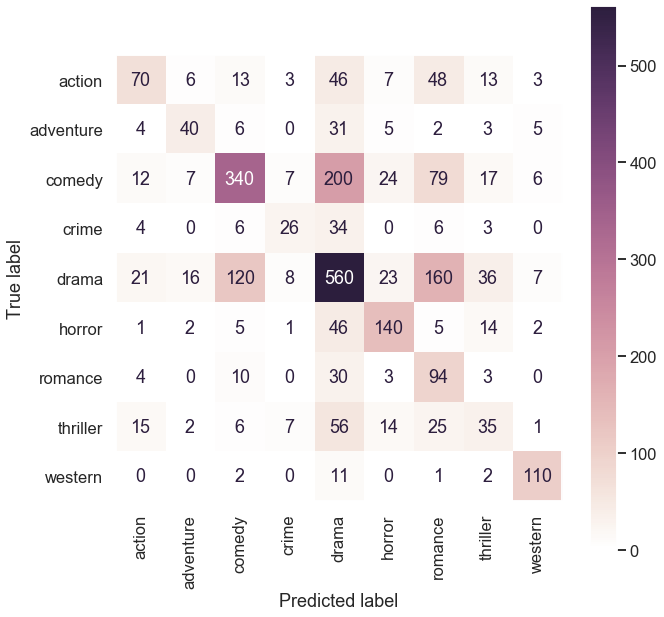

In [35]:
evaluate(model_data)

## 2 – Inspect

In [36]:
print_best_params(model)

alpha       : 0.30000000000000004
class_prior : None
fit_prior   : True


In [37]:
cv_results(get_learner(model))

,param_alpha,mean_test_score,std_test_score,rank_test_score,statistically_different
3,0.3,0.503062,0.013691,1,False
2,0.2,0.501825,0.011248,2,False
4,0.4,0.500567,0.013489,3,False
1,0.1,0.498160,0.012350,4,False
5,0.5,0.497058,0.013406,5,False
6,0.6,0.491873,0.012823,6,True
7,0.7,0.487248,0.012534,7,True
8,0.8,0.482288,0.012530,8,True
9,0.9,0.476809,0.012411,9,True
10,1,0.470841,0.012850,10,True


# Part 2b – Let's avoid using the overall distribution in our classifier
This doesn't seem to help

Loading count-bayes-no-prior from disk
49.933 seconds elapsed in original job
Loading count-bayes-no-prior-y-pred from disk
11.198 seconds elapsed in original job
Loading count-bayes-no-prior-y-pred-prob from disk
12.794 seconds elapsed in original job
Loading count-bayes-no-prior-y-train-pred-prob from disk
32.407 seconds elapsed in original job
----------------------

Log Loss - Train  : 4.2
Log Loss - Test   : 1e+01
Weighted F1 Score :  52.68%
----------------------

              precision    recall  f1-score   support

      action       0.53      0.33      0.41       209
   adventure       0.50      0.40      0.44        96
      comedy       0.66      0.49      0.56       692
       crime       0.36      0.13      0.19        79
       drama       0.53      0.62      0.57       952
      horror       0.64      0.64      0.64       216
     romance       0.26      0.64      0.37       144
    thriller       0.28      0.22      0.25       161
     western       0.83      0.82     

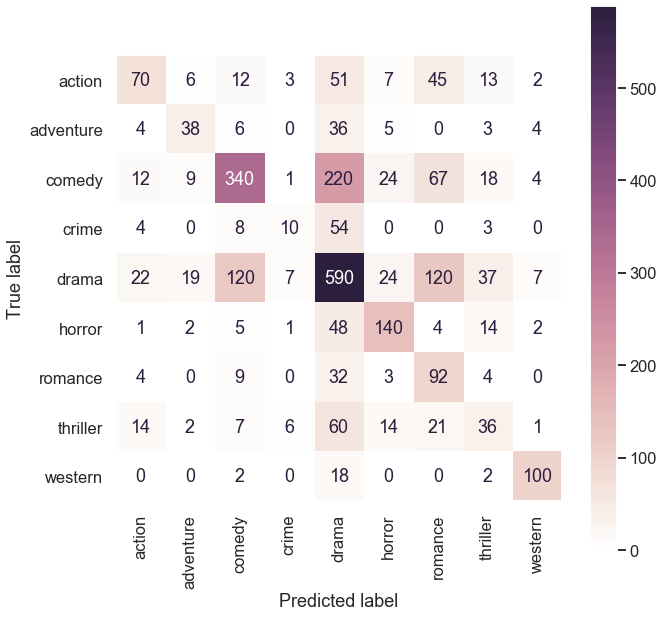

alpha       : 0.4
class_prior : None
fit_prior   : False


,param_alpha,mean_test_score,std_test_score,rank_test_score,statistically_different
4,0.4,0.501003,0.014170,1,False
3,0.3,0.500903,0.012888,2,False
2,0.2,0.497997,0.011939,3,False
5,0.5,0.496727,0.013435,4,False
1,0.1,0.493935,0.012175,5,False
6,0.6,0.492995,0.013611,6,True
7,0.7,0.488179,0.012018,7,True
8,0.8,0.483187,0.012182,8,True
9,0.9,0.477940,0.012061,9,True
10,1,0.472096,0.012375,10,True


In [38]:
# Tracking
model_data    = {'name'    : 'count-bayes-no-prior',
                 'display' : 'count-bayes-no-prior'}
models.append(model_data)

# Learner
base_learner = bayes.MultinomialNB(fit_prior = False)
param_grid   = {
    'alpha' : list(np.linspace(0, 1, 11))
}

learner      = grid_search(base_learner, param_grid)

# Pipeline
model = pipe.Pipeline([
    ('pipe-in', simple_pipe_in),
    ('learn'  , learner)
])

# Fit
model = persist(model_data['name'], model, 'fit', X, y)
model_data['model'] = model

# Evaluate
evaluate(model_data)

# Inspect
print_best_params(model)
cv_results(get_learner(model))

# Part 3: Complement Naive Bayes
Complement Naive Bayes is designed to deal with class imbalances.

Loading count-complement-bayes from disk
75.646 seconds elapsed in original job
Loading count-complement-bayes-y-pred from disk
14.284 seconds elapsed in original job
Loading count-complement-bayes-y-pred-prob from disk
14.596 seconds elapsed in original job
Loading count-complement-bayes-y-train-pred-prob from disk
38.568 seconds elapsed in original job
----------------------

Log Loss - Train  : 0.73
Log Loss - Test   : 4.7
Weighted F1 Score :  51.19%
----------------------

              precision    recall  f1-score   support

      action       0.45      0.36      0.40       209
   adventure       0.62      0.36      0.46        96
      comedy       0.65      0.51      0.57       692
       crime       0.13      0.03      0.04        79
       drama       0.52      0.71      0.60       952
      horror       0.50      0.72      0.59       216
     romance       0.31      0.27      0.29       144
    thriller       0.15      0.03      0.05       161
     western       0.72      0.

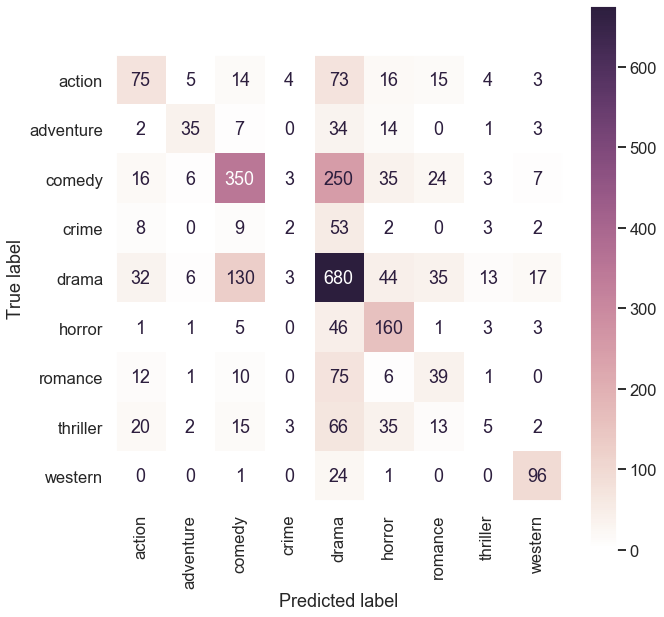

alpha       : 0.1
class_prior : None
fit_prior   : True
norm        : False


,param_alpha,param_norm,mean_test_score,std_test_score,rank_test_score,statistically_different
3,0.1,False,0.488840,0.012563,1,False
5,0.2,False,0.488286,0.012348,2,False
7,0.3,False,0.488267,0.012100,3,False
9,0.4,False,0.487043,0.012060,4,False
11,0.5,False,0.485919,0.011752,5,False
13,0.6,False,0.484494,0.011695,6,True
15,0.7,False,0.483717,0.012523,7,True
17,0.8,False,0.482420,0.012501,8,True
19,0.9,False,0.481768,0.011796,9,True
21,1,False,0.481559,0.011238,10,True


In [39]:
# Tracking
model_data    = {'name'    : 'count-complement-bayes',
                 'display' : 'count-complement-bayes'}

# Learner
base_learner = bayes.ComplementNB()
param_grid   = {
    'alpha' : list(np.linspace(0, 1, 11)),
    'norm'  : [True, False],
}
learner      = grid_search(base_learner, param_grid)

# Pipeline
model = pipe.Pipeline([
    ('pipe-in', simple_pipe_in),
    ('learn'  , learner)
])

# Fit
model = persist(model_data['name'], model, 'fit', X, y)

# Register Data
model_data['model'] = model
models.append(model_data)

# Evaluate
evaluate(model_data)

# Inspect
print_best_params(model)

cv_results(get_learner(model))

# Part 4: Play with the Tokenizer
Can we achieve gains by only tokenizing certain parts of speech?

## 4(i) – Setup
We need to make the Tokenizer grid-searchable

In [41]:
%%time
# Tests show that including tagging is 
#  about 200 times slower (results not shown)
slow_spacy_tokenizer = spacy.load("en_core_web_lg", disable=['parser', 'ner'])

CPU times: user 9.06 s, sys: 2.17 s, total: 11.2 s
Wall time: 12.3 s


In [43]:
# Evade GridSearchCV's repetitive calls to stateless transformers
@functools.lru_cache(maxsize = 16384)
def cached_spacy_tokenizer(string_):
    return slow_spacy_tokenizer(string_)

In [44]:
class Tokenizer(base.BaseEstimator):
    '''
        Grid Searchable Tokenizer using spaCy.
        Calls to the spaCy parser and tagger are 
        *cached* for performance reasons. Beware of
        memory usage. Also, be sure to set the cache
        size based on your dataset size.
    '''
    tokenizer = cached_spacy_tokenizer
    
    def __init__(self, 
                 parts_of_speech = 'all', 
                 lemmatize  = False,
                 allow_oov  = True # Out of spaCy Vocab allowed
                ):
        self.parts_of_speech = parts_of_speech
        self.lemmatize       = lemmatize
        self.allow_oov       = allow_oov
        
    def _token_filter(self, token):
        if self.parts_of_speech != 'all' and \
           token.pos_ not in self.parts_of_speech:
            return False
        if token.is_stop:
            return False
        if token.text in string.punctuation:
            return False
        if not self.allow_oov and token.is_oov:
            return False    
        
        return True
        
    def __call__(self, doc):
        tokens = Tokenizer.tokenizer(doc)
        tokens = filter(self._token_filter, tokens)
        if self.lemmatize:
            return [token.lemma_.lower() for token in tokens]
        else:
            return [token.lower_ for token in tokens]
    
    @classmethod
    def clear_cache(cls):
        '''
            Preserves memory by clearing the cache
        '''
        cls.tokenizer.cache_clear()
        
    @classmethod
    def check_cache(cls):
        '''
            For purposes of debugging/verifying behaviour
            Shows statistics on cache performance
        '''
        return cls.tokenizer.cache_info()
    
    @classmethod
    def precompute(cls, data, force_compute = False):
        '''
            Pre-compute the tokenizer and cache the
            results. Attempt to persist/load from disk
            if possible
        '''
        
        # Warn if the cache is too small
        max_size = cls.tokenizer.cache_info().maxsize
        if len(data) > max_size:
            warnings.warn(
                'The maximum cache size is smaller than'
                ' the data. This will likely not achieve'
                ' speedups since it is an LRU cache and'
                ' will discard information when it fills'
                ' up.'
            )
            
        Timer.start()
        for datum in data:
            cls.tokenizer(datum)
        Timer.end()

## 4(ii) – Precompute the spaCy tokenizer

In [57]:
# Pre-compute on both train and test
#  Memory and time intensive
Tokenizer.precompute(data['plot'])

0.5 seconds elapsed


## 4(iii) – Set up our pipelines

In [ ]:
# Pre-processor
tagged_count_pipe = pipe2.ColumnTransformer([
        ('directors', pre.OneHotEncoder(handle_unknown = 'ignore'), ['director']),
        ('plot_text', text.CountVectorizer(strip_accents= 'unicode', 
                                           lowercase    = True,
                                           analyzer     = Tokenizer(),
                                           min_df       = 2
                                          ),
            'plot'
        ),
        ('rest'     , 'passthrough', ['release_year'])
])

# Learner
base_learner = bayes.ComplementNB()

# Pipeline
learner = pipe.Pipeline([
    ('pipe_in', tagged_count_pipe),
    ('learn'  , base_learner)
])

In [160]:
# A smaller splitter for less intensive grid searches
small_splitter = cv.RepeatedStratifiedKFold(n_repeats = 1, n_splits = 3, random_state = 42)

In [164]:
# Conveniences for handling nested param grids
def prefix_dict(prefix, dict_):
    return {prefix + k : v for k, v in dict_.items()}

def concat_dicts(dicts):
    return dict(itertools.chain.from_iterable(
                map(lambda d : d.items(), dicts)))

tokenizer_prefix = 'plot_text__analyzer__'
def make_grid_search(learner, splitter, *params):
    pipe_steps = lmap(lambda tup : tup[0]+'__', learner.steps)
    assert len(pipe_steps) == len(params)
    params = concat_dicts(map(prefix_dict, pipe_steps, params))
    return cv.GridSearchCV(learner, 
                           params,
                           scoring = f1,
                           n_jobs = -1, 
                           cv = splitter,
                           verbose = 2,
                           refit = True)

In [165]:
# Tokenizer parts of speech
parts_of_speech = ['ADJ', 'ADV', 'INTJ', 'NOUN', 'NUM', 'PROPN', 'VERB']

## 4(iv) Do a small grid search first

Loading tokenizer-grid-search-small from disk
184.414 seconds elapsed in original job
Loading tokenizer-grid-search-small-y-pred from disk
2.584 seconds elapsed in original job
Loading tokenizer-grid-search-small-y-pred-prob from disk
1.734 seconds elapsed in original job
Loading tokenizer-grid-search-small-y-train-pred-prob from disk
5.172 seconds elapsed in original job
----------------------

Log Loss - Train  : 0.67
Log Loss - Test   : 4.8
Weighted F1 Score :  51.38%
----------------------

              precision    recall  f1-score   support

      action       0.44      0.34      0.39       209
   adventure       0.63      0.35      0.45        96
      comedy       0.65      0.52      0.58       692
       crime       0.12      0.03      0.04        79
       drama       0.53      0.71      0.60       952
      horror       0.51      0.71      0.59       216
     romance       0.31      0.27      0.29       144
    thriller       0.18      0.04      0.06       161
     western 

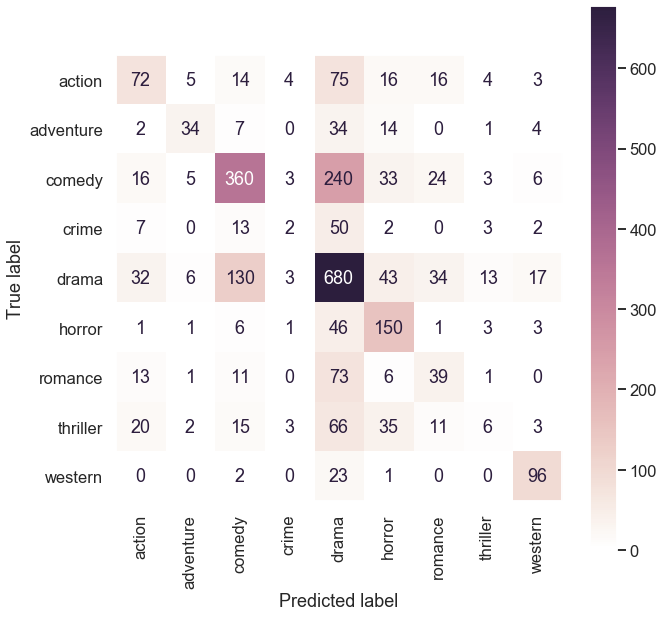

,param_pipe_in__plot_text__analyzer__allow_oov,param_pipe_in__plot_text__analyzer__lemmatize,param_learn__alpha,mean_test_score,std_test_score,rank_test_score,statistically_different
1,True,False,0.05,0.491315,0.013308,1,False
0,True,True,0.05,0.490263,0.012146,2,False
5,True,False,0.15,0.488989,0.012899,3,False
3,False,False,0.05,0.487901,0.010074,4,False
9,True,False,0.25,0.487816,0.014150,5,False
4,True,True,0.15,0.487462,0.011160,6,False
2,False,True,0.05,0.487232,0.008484,7,False
13,True,False,0.35,0.487217,0.012751,8,False
17,True,False,0.45,0.485865,0.012443,9,False
7,False,False,0.15,0.485323,0.010680,10,False


In [200]:
# Tracking
model_data    = {'name'    : 'tokenizer-grid-search-small',
                 'display' : 'tokenizer-grid-search-small'}


# Parameters for Grid Search
tokenizer_param_grid = {
    'allow_oov' : [True, False],
    'lemmatize' : [True, False],
}
learner_param_grid   = {
    'alpha' : list(np.linspace(0.05, 0.45, 5))
}

# Build and Fit the Model
tokenizer_param_grid = prefix_dict(tokenizer_prefix, tokenizer_param_grid)
model = make_grid_search(learner, easy_splitter, tokenizer_param_grid, learner_param_grid)
with joblib.parallel_backend('multiprocessing'):
    model = persist(model_data['name'], model, 'fit', X, y)

# Register Data
model_data['model'] = model
models.append(model_data)

# Evaluate
evaluate(model_data)

# Inspect
cv_results(model)

### 4(v) – Medium Size Grid Search

In [170]:
def powerset(list_, sizes = None):
    if not sizes:
        sizes = range(1, len(list_)+1)
    return list(itertools.chain.from_iterable(
                itertools.combinations(list_, r) for r in sizes))

Loading tokenizer-grid-search-medium from disk
6503.426 seconds elapsed in original job
Loading tokenizer-grid-search-medium-y-pred from disk
1.646 seconds elapsed in original job
Loading tokenizer-grid-search-medium-y-pred-prob from disk
1.276 seconds elapsed in original job
Loading tokenizer-grid-search-medium-y-train-pred-prob from disk
3.903 seconds elapsed in original job
----------------------

Log Loss - Train  : 0.55
Log Loss - Test   : 2.0
Weighted F1 Score :  56.39%
----------------------

              precision    recall  f1-score   support

      action       0.51      0.44      0.47       209
   adventure       0.57      0.38      0.45        96
      comedy       0.69      0.57      0.62       692
       crime       0.52      0.20      0.29        79
       drama       0.58      0.73      0.65       952
      horror       0.55      0.84      0.66       216
     romance       0.39      0.24      0.29       144
    thriller       0.26      0.07      0.11       161
     wes

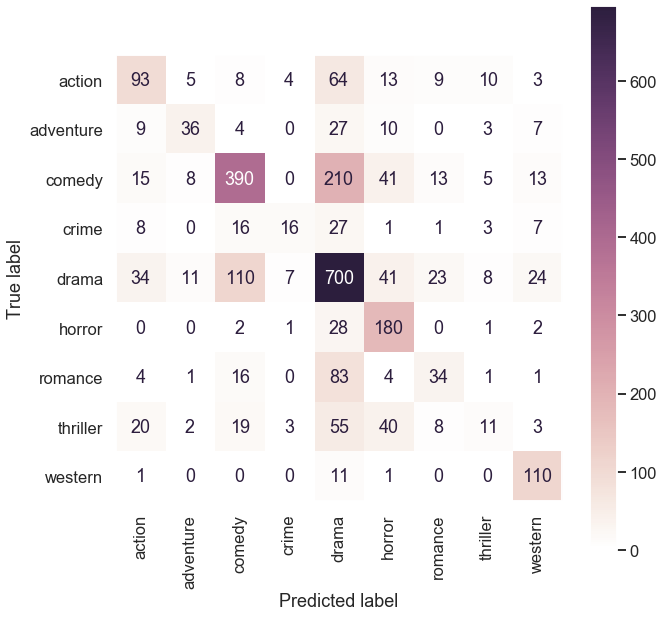

,param_pipe_in__plot_text__analyzer__allow_oov,param_pipe_in__plot_text__analyzer__lemmatize,param_pipe_in__plot_text__analyzer__parts_of_speech,param_learn__alpha,mean_test_score,std_test_score,rank_test_score,statistically_different
427,False,False,"(ADJ, ADV, INTJ, NOUN, NUM)",0.15,0.531703,0.005824,1,False
313,True,False,"(ADJ, ADV, INTJ, NOUN, NUM)",0.15,0.531063,0.005829,2,False
28,True,True,"(ADJ, ADV, INTJ, NOUN, NUM)",0.05,0.530429,0.004824,3,False
85,True,False,"(ADJ, ADV, INTJ, NOUN, NUM)",0.05,0.530248,0.006501,4,False
142,False,True,"(ADJ, ADV, INTJ, NOUN, NUM)",0.05,0.530163,0.006328,5,False
...,...,...,...,...,...,...,...,...
4,True,True,"(NUM,)",0.05,0.352339,0.021584,1135,True
19,True,True,"(INTJ, NUM)",0.05,0.352111,0.023049,1137,True
133,False,True,"(INTJ, NUM)",0.05,0.352111,0.023049,1137,True
76,True,False,"(INTJ, NUM)",0.05,0.352111,0.023049,1137,True


In [201]:
# Tracking
model_data    = {'name'    : 'tokenizer-grid-search-medium',
                 'display' : 'tokenizer-grid-search-medium'}

# Parameters for Grid Search
tokenizer_param_grid = {
    'allow_oov' : [True, False],
    'lemmatize' : [True, False],
    'parts_of_speech' : powerset(parts_of_speech, sizes = [1, 2, 5, 6, 7]) # 57 options, could take a while
}
learner_param_grid   = {
    'alpha' : list(np.linspace(0.05, 0.45, 5))
}

# Build and Fit the Model
tokenizer_param_grid = prefix_dict(tokenizer_prefix, tokenizer_param_grid)
model = make_grid_search(learner, easy_splitter, tokenizer_param_grid, learner_param_grid)
with joblib.parallel_backend('multiprocessing'):
    model = persist(model_data['name'], model, 'fit', X, y)

# Register Data
model_data['model'] = model
models.append(model_data)

# Evaluate
evaluate(model_data)

# Inspect
cv_df = cv_results(model)
cv_df

In [207]:
parts_of_speech_to_try = cv_df[~cv_df.statistically_different].param_pipe_in__plot_text__analyzer__parts_of_speech.unique()
print(f'Number of decently performing part-of-speech combinations: {parts_of_speech_to_try}')

Number of decently performing part-of-speech combinations: [('ADJ', 'ADV', 'INTJ', 'NOUN', 'NUM') ('ADJ', 'NOUN') ('ADV', 'NOUN')
 ('NOUN', 'NUM') ('INTJ', 'NOUN') ('NOUN',)
 ('ADJ', 'ADV', 'NOUN', 'NUM', 'VERB')
 ('ADJ', 'ADV', 'INTJ', 'NOUN', 'VERB')
 ('ADJ', 'ADV', 'INTJ', 'NOUN', 'NUM', 'VERB')
 ('ADJ', 'INTJ', 'NOUN', 'NUM', 'VERB')
 ('ADV', 'INTJ', 'NOUN', 'NUM', 'VERB') ('NOUN', 'VERB')
 ('ADJ', 'INTJ', 'NOUN', 'NUM', 'PROPN', 'VERB')
 ('ADJ', 'ADV', 'INTJ', 'NOUN', 'NUM', 'PROPN', 'VERB')
 ('ADJ', 'NOUN', 'NUM', 'PROPN', 'VERB')
 ('ADJ', 'ADV', 'NOUN', 'NUM', 'PROPN')
 ('ADJ', 'ADV', 'INTJ', 'NOUN', 'NUM', 'PROPN')
 ('ADJ', 'ADV', 'NOUN', 'NUM', 'PROPN', 'VERB')
 ('ADJ', 'INTJ', 'NOUN', 'NUM', 'PROPN')
 ('ADJ', 'ADV', 'INTJ', 'NOUN', 'PROPN')
 ('ADJ', 'INTJ', 'NOUN', 'PROPN', 'VERB')
 ('ADJ', 'ADV', 'INTJ', 'NOUN', 'PROPN', 'VERB')
 ('ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB')
 ('ADV', 'INTJ', 'NOUN', 'NUM', 'PROPN', 'VERB')
 ('ADV', 'NOUN', 'NUM', 'PROPN', 'VERB')
 ('ADV', 'INTJ', 

# Part 5: SMOTE

In [241]:
import imblearn.over_sampling as imb
import imblearn.pipeline      as imb_pipe

In [242]:
# I tried this with an imblearn pipeline but it has 
#  its own performance issues with hashing
# cache = joblib.Memory('./models', verbose = False)

Loading smote-one from disk
11464.264 seconds elapsed in original job
Loading smote-one-y-pred from disk
1.597 seconds elapsed in original job
Loading smote-one-y-pred-prob from disk
1.92 seconds elapsed in original job
Loading smote-one-y-train-pred-prob from disk
3.727 seconds elapsed in original job
----------------------

Log Loss - Train  : 0.73
Log Loss - Test   : 2.5
Weighted F1 Score :  49.40%
----------------------

              precision    recall  f1-score   support

      action       0.52      0.41      0.46       209
   adventure       0.36      0.68      0.47        96
      comedy       0.67      0.50      0.57       692
       crime       0.18      0.67      0.28        79
       drama       0.67      0.38      0.49       952
      horror       0.57      0.86      0.68       216
     romance       0.20      0.53      0.29       144
    thriller       0.24      0.10      0.14       161
     western       0.55      0.92      0.69       122

    accuracy                 

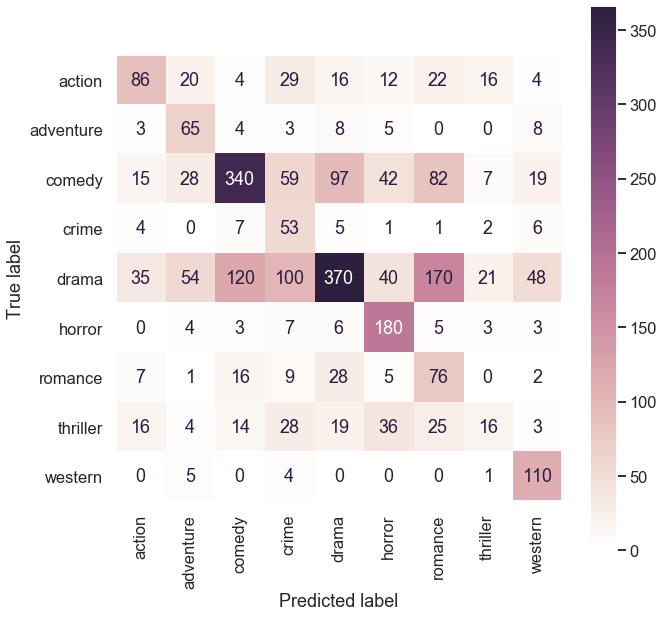

cv                                                       : RepeatedStratifiedKFold(n_repeats=1, n_splits=3, random_state=42)
error_score                                              : nan
estimator__memory                                        : None
estimator__steps                                         : [('pipe-in', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('directors',
                                 OneHotEncoder(categories='auto', drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='ignore',
                                               sparse=True),
                                 ['director']),
                                ('plot_text',
                                 CountVectorizer(analyzer=Tokenizer(allow_oov=True,
                                                 

,param_pipe-in__plot_text__analyzer__allow_oov,param_pipe-in__plot_text__analyzer__lemmatize,param_pipe-in__plot_text__analyzer__parts_of_speech,param_smote__k_neighbors,param_learn__alpha,mean_test_score,std_test_score,rank_test_score,statistically_different
480,False,False,"(ADJ, NOUN)",3,0.05,0.472153,0.003709,1,False
208,True,False,"(ADJ, NOUN)",3,0.05,0.471954,0.003943,2,False
481,False,False,"(ADJ, NOUN)",5,0.05,0.471417,0.003456,3,False
209,True,False,"(ADJ, NOUN)",5,0.05,0.471204,0.003055,4,False
412,False,False,"(ADJ, ADV, INTJ, NOUN, NUM)",3,0.05,0.470732,0.008155,5,False
...,...,...,...,...,...,...,...,...,...
1197,True,True,"(ADV, VERB)",5,0.25,0.355478,0.008586,1628,True
1196,True,True,"(ADV, VERB)",3,0.25,0.353731,0.014947,1629,True
1468,False,True,"(ADV, VERB)",3,0.25,0.352820,0.015251,1630,True
1471,False,True,"(ADV, VERB)",11,0.25,0.351838,0.012098,1631,True


In [246]:
# Tracking
model_data    = {'name'    : 'smote-one',
                 'display' : 'smote-one'}

# Learner
base_learner = bayes.ComplementNB()

# Pipeline
learner = imb_pipe.Pipeline([
    ('pipe-in', tagged_count_pipe),
    ('smote'  , imb.SMOTE(random_state = 42)),
    ('learn'  , base_learner)
])

# Param Grids
tokenizer_param_grid = {
    'allow_oov' : [True, False],
    'lemmatize' : [True, False],
    'parts_of_speech' : parts_of_speech_to_try
}
smote_param_grid = {
    'k_neighbors' : [3, 5, 7, 11]
}
learner_param_grid   = {
    'alpha' : list(np.linspace(0.05, 0.25, 3))
}

tokenizer_param_grid = prefix_dict(tokenizer_prefix, tokenizer_param_grid)

# Grid Search
model = make_grid_search(learner, easy_splitter, tokenizer_param_grid, smote_param_grid, learner_param_grid)

# Fit
# Build and Fit the Model
with joblib.parallel_backend('multiprocessing'):
    model = persist(model_data['name'], model, 'fit', X, y)

# Register Data
model_data['model'] = model
models.append(model_data)

# Evaluate
evaluate(model_data)

# Inspect
print_best_params(model)

cv_results(model)

# End: Compare Models

In [ ]:
# for model_name, model_data in models.items():
#     model_data['model_name'] = model_name

# model_records = list(models.values())

# model_df = pd.io.json.json_normalize(model_records)

# table = {
#     'model_name'                : 'Model',
#     'report.True.precision'     : 'Precision',
#     'report.True.recall'        : 'Recall',
#     'report.True.f1-score'      : 'F1',
#     'auc'                       : 'AUC',
#     'log_loss_train'            : 'Cross-Entropy (Train)',
#     'log_loss_test'             : 'Cross-Entropy (Test)',
#     'fit_time'                  : 'Fit Time',
#     'get_time_per_fold'         : 'Time per Fold*',
# }

# table = model_df[table.keys()].rename(table, axis = 'columns')
# table.to_csv('./tables/model-table.csv')

# table

# model_name_dict = {
#          'baseline' : 'Baseline'                ,
#          'logistic' : 'Logistic'                ,
# 'logistic-weighted' : 'Logistic (Balanced)'     ,
#     'decision-tree' : 'Decision Tree'           ,
#     'random-forest' : 'Random Forest'           ,
#          'adaboost' : 'AdaBoost'                ,
#     'gradientboost' : 'Gradient Boost'          

# }

# fig, ax = plt.subplots(figsize = (10, 10))

# for model in model_records:
#     try:
#         ax.plot(*model['roc'], label = model_name_dict[model['model_name']])
#     except KeyError:
#         continue
        
# xs = np.linspace(0, 1, len(fpr))
# ax.plot(xs, xs, label = 'Dummy')
# ax.set_xlim([-0.0, 1.0])
# ax.set_ylim([0.0, 1.0])
# ax.set_title('ROC Curve')
# ax.set_xlabel('False Positive Rate (1 - Specificity)')
# ax.set_ylabel('True Positive Rate (Sensitivity)')
# ax.grid(True)
# ax.set_aspect(1)
# ax.legend()

# # fig.savefig('./figures/roc_curve.pdf')     
# fig.savefig('./figures/roc_curve.png')     
# fig

# # Predict
# This is for people who want to take the survey themselves